In [3]:
!uv sync
import math
from collections.abc import Iterable
from itertools import pairwise, chain
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import polars as pl
import seaborn as sns
import tqdm.auto as tqdm
from torch import nn

import pytorch_semifield_conv

Resolved 163 packages in 0.69ms
Prepared 2 packages in 134ms                                             
Uninstalled 2 packages in 0.44ms
Installed 2 packages in 0.64ms-jit==0.1.0 (from file:///home
 ~ pytorch-numba-extension-jit==0.1.0 (from file:///home/peter/Thesis/pytorch-numba-extension-jit)
 ~ pytorch-semifield-conv==0.1.0 (from file:///home/peter/Thesis/pytorch-semifield-conv)


In [4]:
from pathlib import Path
import os

if not Path("./src/models").is_dir():
    for parent_path in Path.cwd().parents:
        if (parent_path / "src/models").is_dir():
            os.chdir(parent_path)
            break
    else:
        raise FileNotFoundError("Can't find project root")

assert Path("./src/models").is_dir()

In [5]:
from src.models import LeNet, EXAMPLE_POOLING_FUNCTIONS, CIFAR10CNN
from src.models.utils import HistoryCallback, make_pooling_function
from src import load_data

In [6]:
torch.set_float32_matmul_precision("high")
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [7]:
k_mnist = load_data.k_mnist()
k_mnist

Dataset(x_train=torch.Size([60000, 1, 28, 28]), x_test=torch.Size([10000, 1, 28, 28]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [8]:
fashion = load_data.fashion_mnist()
fashion

Dataset(x_train=torch.Size([60000, 1, 28, 28]), x_test=torch.Size([10000, 1, 28, 28]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [9]:
cifar10 = load_data.cifar10()
cifar10

Dataset(x_train=torch.Size([50000, 3, 32, 32]), x_test=torch.Size([10000, 3, 32, 32]), y_train=torch.Size([50000]), y_test=torch.Size([10000]))

In [10]:
# svhn = load_data.svhn()
# svhn

In [11]:
import polars as pl
pl.read_parquet("./.data/long_cifar10.pq").select(pl.all().struct.field("train_times").name.keep())

standard-3,standard-5,iso-3-ss,iso-5-ss,iso-7-ss,iso-11-ss,aniso-3-ss-iso-spin,aniso-3-skewed-spin,aniso-5-ss-iso-spin,aniso-5-skewed-spin,aniso-7-ss-iso-spin,aniso-7-skewed-spin,aniso-11-ss-iso-spin,aniso-11-skewed-spin
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
68.740147,80.11701,92.305714,89.836278,93.226995,110.150128,93.798665,92.775127,90.455962,89.567513,94.695094,93.380776,111.925658,110.007044
68.747477,80.112786,92.146772,89.913601,92.523616,109.607647,93.725877,93.151525,90.540291,89.583,93.535343,93.36081,111.204387,110.035252
68.751884,80.165429,91.655757,89.853347,92.208816,109.707598,93.179,92.627299,90.269806,89.558367,93.633887,92.961199,111.063322,109.941157
68.725923,80.134971,91.32497,89.450791,92.896447,109.201995,92.536318,92.616758,90.615401,89.641805,94.129997,93.220234,111.359533,110.005272
68.742927,80.164321,91.525544,89.728817,92.408298,109.545065,92.551035,92.965813,91.032676,89.246228,94.235032,92.821746,110.799829,110.305041
…,…,…,…,…,…,…,…,…,…,…,…,…,…
68.735018,80.107499,91.95502,89.827373,92.409894,110.233148,93.979663,92.916192,90.390094,90.098252,93.699912,92.803049,111.166945,110.335655
68.740986,80.12903,92.673685,88.914333,92.593966,109.507383,93.18824,93.930583,90.702438,89.888496,94.285752,92.665521,110.909121,110.548491
68.75353,80.171183,92.583974,89.011528,92.689459,109.413752,93.376867,92.27494,90.30647,89.362412,93.716054,92.90106,110.410792,110.048758


In [10]:
LeNet.fit_many(fashion, epochs=80, batch_size=1024, lr=0.003,
               pool_fn=make_pooling_function("aniso", 7), torch_compile_mode="reduce-overhead",
               count=5, init={"var": "ss-iso", "theta": "spin"}).scores

<function make_pooling_function.<locals>.pooling_fn at 0x775f553b60c0>:{'var': 'ss-iso', 'theta': 'spin'}:   0…

acc,min_f1,max_f1,macro_f1,train_times,compile_times,times
f64,f64,f64,f64,f64,f64,f64
0.912326,0.753955,0.985667,0.91258,6.239936,2.329829,8.569764
0.911241,0.751087,0.98573,0.911426,5.57584,0.133363,5.709203
0.913086,0.753045,0.987925,0.913002,5.568425,0.13153,5.699955
0.908312,0.738313,0.985683,0.908656,5.597868,0.13497,5.732838
0.91135,0.74604,0.987356,0.911477,5.575227,0.147782,5.723008


In [7]:
CIFAR10CNN.fit_many(cifar10, batch_size=64, lr=0.001, pool_fn="aniso-7", init={"var": "ss-iso", "theta": "spin"},
                    count=3, epochs=100)

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/3 [00:00<?, ?run/s]

FitManyResult(scores=shape: (3, 7)
┌──────────┬──────────┬──────────┬──────────┬─────────────┬───────────────┬────────────┐
│ acc      ┆ min_f1   ┆ max_f1   ┆ macro_f1 ┆ train_times ┆ compile_times ┆ times      │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---         ┆ ---           ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64         ┆ f64           ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═════════════╪═══════════════╪════════════╡
│ 0.870893 ┆ 0.742026 ┆ 0.944081 ┆ 0.869488 ┆ 175.139215  ┆ 2.860776      ┆ 177.999991 │
│ 0.869191 ┆ 0.744887 ┆ 0.940998 ┆ 0.868265 ┆ 187.957692  ┆ 0.004232      ┆ 187.961924 │
│ 0.868189 ┆ 0.744312 ┆ 0.944444 ┆ 0.866933 ┆ 192.867767  ┆ 0.004079      ┆ 192.871845 │
└──────────┴──────────┴──────────┴──────────┴─────────────┴───────────────┴────────────┘, models=None)

In [14]:
CIFAR10CNN.fit_many(cifar10, batch_size=1024, lr=0.004, pool_fn="standard-7", torch_compile_mode="reduce-overhead",
                    count=3, epochs=150)

standard-7:None:   0%|          | 0/3 [00:00<?, ?run/s]

FitManyResult(scores=shape: (3, 7)
┌──────────┬──────────┬──────────┬──────────┬─────────────┬───────────────┬───────────┐
│ acc      ┆ min_f1   ┆ max_f1   ┆ macro_f1 ┆ train_times ┆ compile_times ┆ times     │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---         ┆ ---           ┆ ---       │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64         ┆ f64           ┆ f64       │
╞══════════╪══════════╪══════════╪══════════╪═════════════╪═══════════════╪═══════════╡
│ 0.831055 ┆ 0.648512 ┆ 0.917509 ┆ 0.828364 ┆ 82.038755   ┆ 1.86901       ┆ 83.907765 │
│ 0.834201 ┆ 0.663438 ┆ 0.917499 ┆ 0.832163 ┆ 73.389583   ┆ 0.264502      ┆ 73.654084 │
│ 0.828776 ┆ 0.675041 ┆ 0.921397 ┆ 0.8291   ┆ 73.386047   ┆ 0.260004      ┆ 73.646051 │
└──────────┴──────────┴──────────┴──────────┴─────────────┴───────────────┴───────────┘, models=None)

In [8]:
CIFAR10CNN.fit_many(cifar10, batch_size=64, lr=0.001, pool_fn="standard-2",
                    count=3, epochs=100)

standard-2:None:   0%|          | 0/3 [00:00<?, ?run/s]

KeyboardInterrupt: 

In [8]:
CIFAR10CNN.fit_many(svhn, batch_size=1024, lr=0.004, pool_fn="aniso-7", init={"var": "ss-iso", "theta": "spin"},
                    count=3, epochs=100)

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/3 [00:00<?, ?run/s]

KeyboardInterrupt: 

In [16]:
cifar10

Dataset(x_train=torch.Size([50000, 3, 32, 32]), x_test=torch.Size([10000, 3, 32, 32]), y_train=torch.Size([50000]), y_test=torch.Size([10000]))

In [27]:
import numpy as np


class InspectScalesCallback:
    store_targets = {
        kernels.quadratic.QuadraticKernelIso2D: ("log_std",),
        kernels.quadratic.CovSpectral2D: ("log_std", "theta"),
    }

    def __init__(self):
        self.mod_counter = None
        self.store = {}

    def __call__(self, model: nn.Module, _):
        self.mod_counter = 0
        self._recurse_mod(model.net)

    def _recurse_mod(self, mod: torch.nn.Module):
        for child in mod.children():
            cls = type(child)
            if cls not in self.store_targets:
                self._recurse_mod(child)
                continue

            num, self.mod_counter = self.mod_counter, self.mod_counter + 1
            targets = self.store_targets[cls]
            for target in targets:
                val = getattr(child, target).squeeze().numpy(force=True)
                self.store.setdefault(f"{num}.{target}", []).append(val)

    def result(self, count: int = None):
        res = {}
        for name, vals in self.store.items():
            if count is None:
                res[name] = np.stack(vals)
            else:
                stacked = np.stack(vals)
                assert stacked.shape[0] % count == 0, "Total epochs not divisible by count?"
                res[name] = stacked.reshape((count, stacked.shape[0] // count, *stacked.shape[1:]))

        return res

In [62]:
km_large = k_mnist.upsample(5)
km_large

Dataset(x_train=torch.Size([60000, 1, 140, 140]), x_test=torch.Size([10000, 1, 140, 140]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [58]:
torch.set_float32_matmul_precision('high')

In [63]:
isc = InspectScalesCallback()
res = LeNet.fit_many(km_large, epochs=50, batch_size=1024, lr=0.004,
                     pool_fn=make_pooling_function("aniso", 14, group_broadcasting=True), epoch_callback=isc,
                     conv_dilation=5,
                     # conv_kernel_size=16,
                     count=3, init={"var": "skewed", "theta": "spin"}).scores
scales_normal = isc.result(3)
print(res)

<function make_pooling_function.<locals>.pooling_fn at 0x717e346d4680>:{'var': 'skewed', 'theta': 'spin'}:   0…

shape: (3, 7)
┌──────────┬──────────┬──────────┬──────────┬─────────────┬───────────────┬────────────┐
│ acc      ┆ min_f1   ┆ max_f1   ┆ macro_f1 ┆ train_times ┆ compile_times ┆ times      │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---         ┆ ---           ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64         ┆ f64           ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═════════════╪═══════════════╪════════════╡
│ 0.940104 ┆ 0.907982 ┆ 0.9554   ┆ 0.940055 ┆ 570.983477  ┆ 23.05056      ┆ 594.034036 │
│ 0.9426   ┆ 0.920951 ┆ 0.955828 ┆ 0.942492 ┆ 574.293987  ┆ 0.001912      ┆ 574.295899 │
│ 0.947483 ┆ 0.922732 ┆ 0.961332 ┆ 0.947355 ┆ 584.659129  ┆ 0.002008      ┆ 584.661137 │
└──────────┴──────────┴──────────┴──────────┴─────────────┴───────────────┴────────────┘


In [15]:
isc = InspectScalesCallback()
res = LeNet.fit_many(km_large, epochs=100, batch_size=1024, lr=0.004,
                     pool_fn=make_pooling_function("aniso", 14), epoch_callback=isc,
                     conv_dilation=3,
                     # conv_kernel_size=16,
                     count=3, init={"var": "skewed", "theta": "spin"}).scores
scales_alt = isc.result(3)
print(res)

<function make_pooling_function.<locals>.pooling_fn at 0x717eb44428e0>:{'var': 'skewed', 'theta': 'spin'}:   0…

shape: (3, 7)
┌──────────┬──────────┬──────────┬──────────┬─────────────┬───────────────┬────────────┐
│ acc      ┆ min_f1   ┆ max_f1   ┆ macro_f1 ┆ train_times ┆ compile_times ┆ times      │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---         ┆ ---           ┆ ---        │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆ f64         ┆ f64           ┆ f64        │
╞══════════╪══════════╪══════════╪══════════╪═════════════╪═══════════════╪════════════╡
│ 0.958767 ┆ 0.941942 ┆ 0.972566 ┆ 0.958759 ┆ 170.386013  ┆ 0.120121      ┆ 170.506134 │
│ 0.950195 ┆ 0.917021 ┆ 0.9718   ┆ 0.950282 ┆ 169.987986  ┆ 0.001907      ┆ 169.989894 │
│ 0.95855  ┆ 0.939111 ┆ 0.973556 ┆ 0.958489 ┆ 170.249083  ┆ 0.001863      ┆ 170.250945 │
└──────────┴──────────┴──────────┴──────────┴─────────────┴───────────────┴────────────┘


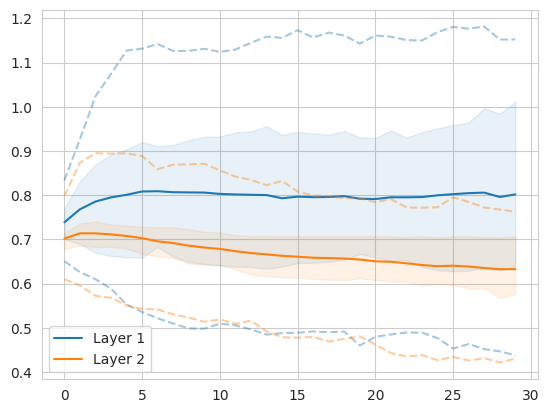

In [54]:
def plot_ci(vals: np.ndarray, ax: plt.Axes = None, label: str = ""):
    assert len(vals.shape) == 2, "Cannot plot multiple val types"
    if ax is None:
        _, ax = plt.subplots()

    q0, q1, q3, q4 = np.quantile(vals, [0, 0.25, 0.75, 1], axis=1)
    colour = ax.plot(vals.mean(axis=1), label=label)[0].get_color()
    ax.plot(q0, color=colour, linestyle="dashed", alpha=0.4)
    ax.plot(q4, color=colour, linestyle="dashed", alpha=0.4)
    ax.fill_between(range(len(vals)), q1, q3, color=colour, alpha=0.1)


_, test_ax = plt.subplots()
plot_ci(np.exp(scales["0.log_std"][0, ..., 0]), ax=test_ax, label="Layer 1")
# plot_ci(scales['0.theta'][0] % (2 * np.pi), ax=test_ax, label="Layer 1")
plot_ci(np.exp(scales["1.log_std"][0, ..., 0]), ax=test_ax, label="Layer 2")
# plot_ci(scales['1.theta'][0] % (2 * np.pi), ax=test_ax, label="Layer 2")
plt.legend()

In [36]:
scales_normal["1.log_std"].shape

(3, 50, 2)

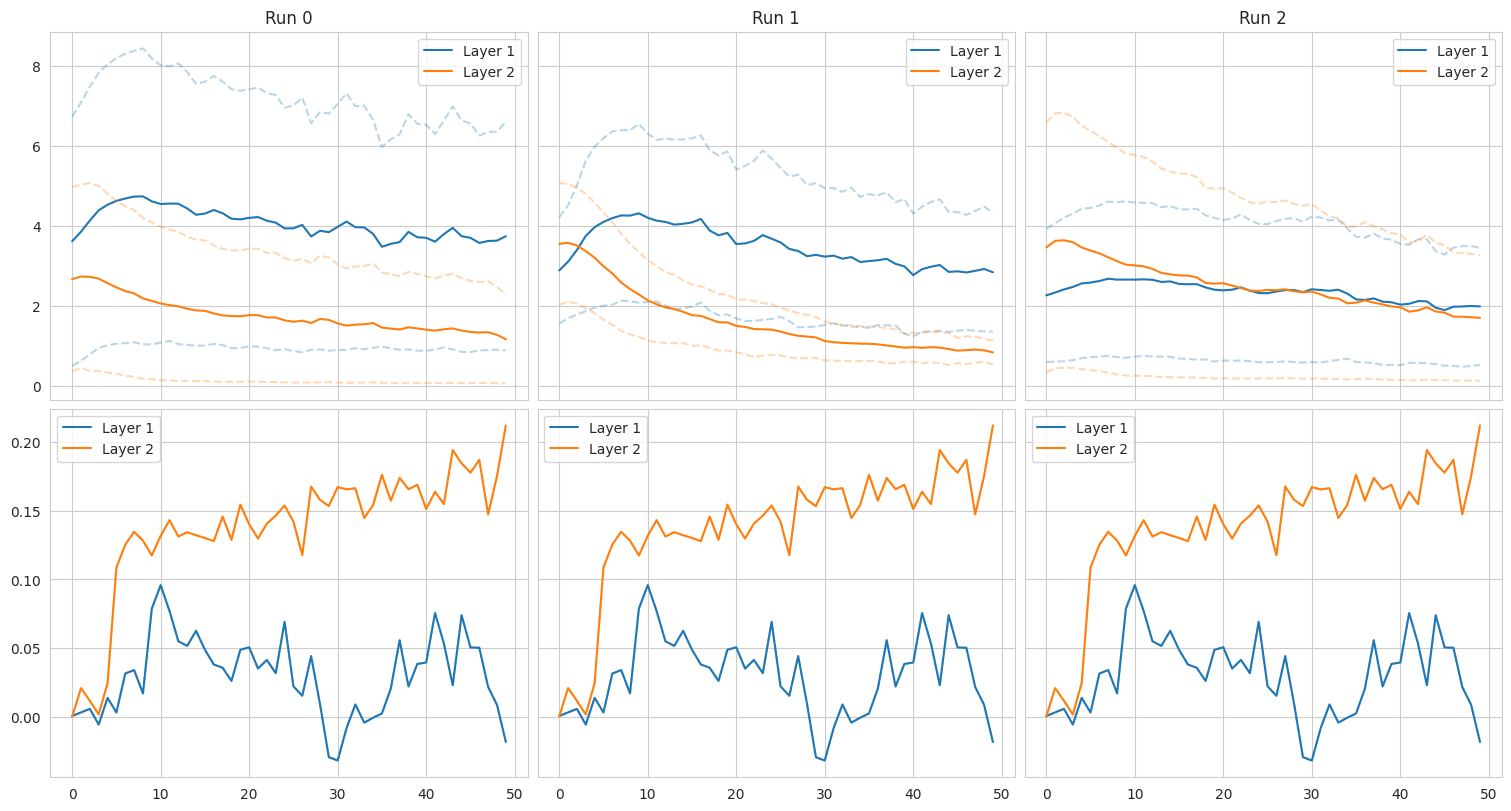

In [64]:
def plot_multi(vals: np.ndarray, ax: plt.Axes = None, label: str = ""):
    assert len(vals.shape) <= 2, "Cannot plot multiple val types"
    if len(vals.shape) == 1:
        vals = vals.reshape((-1, 1))
    if ax is None:
        _, ax = plt.subplots()

    colour = ax.plot(vals.mean(axis=1), label=label)[0].get_color()
    for channel in range(vals.shape[1]):
        ax.plot(vals[:, channel], color=colour, linestyle="dashed", alpha=0.3)


n_models = 3
sc = scales_normal
is_broadcast = len(sc["0.log_std"].shape) == 3
reduce_axes = () if is_broadcast else (-1)
_, (ax_hi, ax_lo) = plt.subplots(nrows=2, ncols=n_models, layout="compressed", figsize=(15, 8), sharex=True,
                                 sharey="row")
for i, test_ax in enumerate(ax_hi):
    test_ax.set_title(f"Run {i}")
    plot_multi(np.exp(2 * sc["0.log_std"][i].max(reduce_axes)), ax=test_ax, label="Layer 1")
    # plot_multi(sc['0.theta'][0], ax=test_ax, label="Layer 1")
    plot_multi(np.exp(2 * sc["1.log_std"][i].max(reduce_axes)), ax=test_ax, label="Layer 2")
    # plot_multi(sc['1.theta'][0], ax=test_ax, label="Layer 2")
    test_ax.legend()

for i, test_ax in enumerate(ax_lo):
    # plot_multi(np.exp(2 * sc["0.log_std"][i].min(reduce_axes)), ax=test_ax, label="Layer 1")
    plot_multi(sc['0.theta'][0], ax=test_ax, label="Layer 1")
    # plot_multi(np.exp(2 * sc["1.log_std"][i].min(reduce_axes)), ax=test_ax, label="Layer 2")
    plot_multi(sc['1.theta'][0], ax=test_ax, label="Layer 2")
    test_ax.legend()

In [9]:
kernels.QuadraticKernelIso2D(1, 1, 5, init=3.7)()

tensor([[[[-0.5405, -0.3378, -0.2703, -0.3378, -0.5405],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.2703, -0.0676, -0.0000, -0.0676, -0.2703],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.5405, -0.3378, -0.2703, -0.3378, -0.5405]]]],
       grad_fn=<ViewBackward0>)

In [11]:
# importlib.reload(src.kernels.utils)
# importlib.reload(src.kernels.quadratic)
# importlib.reload(src.kernels)
k2 = kernels.QuadraticKernelSpectral2D(1, 1, 5, init=3.7)
k3 = kernels.QuadraticKernelCholesky2D(1, 1, 5, init=3.7)
k2()

tensor([[[[-0.5405, -0.3378, -0.2703, -0.3378, -0.5405],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.2703, -0.0676, -0.0000, -0.0676, -0.2703],
          [-0.3378, -0.1351, -0.0676, -0.1351, -0.3378],
          [-0.5405, -0.3378, -0.2703, -0.3378, -0.5405]]]],
       grad_fn=<MulBackward0>)

In [186]:
k2.covs.cov()

tensor([[[[3.0000, 0.0000],
          [0.0000, 3.0000]]]], grad_fn=<LinalgInvExBackward0>)

In [13]:
if "res" not in globals():
    res = {}
res = res

In [139]:
importlib.reload(src.models.trainer)
importlib.reload(src.models.simple_lenet)
importlib.reload(src.models)
importlib.reload(src.load_data)
importlib.reload(src.kernels.quadratic)
importlib.reload(src.kernels)
from src.models import LeNet, EXAMPLE_POOLING_FUNCTIONS
from src import load_data

# pool_fn = 'iso-5'
for pool_fn in tqdm.tqdm(EXAMPLE_POOLING_FUNCTIONS, desc="Pooling types", unit="trial"):
    res[pool_fn] = LeNet.fit_many(k_mnist, pool_fn=pool_fn, init="uniform", batch_size=1024, epochs=30)

Pooling types:   0%|          | 0/10 [00:00<?, ?trial/s]

standard-2:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

standard-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

iso-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-3:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:uniform:   0%|          | 0/20 [00:00<?, ?run/s]

In [254]:
for size in tqdm.tqdm((3, 5, 7), desc="Aniso sizes", unit="trial"):
    res[f"aniso-{size}-spin"] = LeNet.fit_many(k_mnist, pool_fn=f"aniso-{size}", init="spin", batch_size=1024,
                                               epochs=30, lr=0.004)
    res[f"aniso-{size}-uiso"] = LeNet.fit_many(k_mnist, pool_fn=f"aniso-{size}", init="uniform-iso", batch_size=1024,
                                               epochs=30, lr=0.004)

Aniso sizes:   0%|          | 0/3 [00:00<?, ?trial/s]

aniso-3:spin:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-3:uniform-iso:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:spin:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-5:uniform-iso:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:spin:   0%|          | 0/20 [00:00<?, ?run/s]

aniso-7:uniform-iso:   0%|          | 0/20 [00:00<?, ?run/s]

dict_keys(['iso-5', 'lr=0.001', 'lr=0.0016681005372000592', 'lr=0.0027825594022071257', 'lr=0.004641588833612777', 'lr=0.007742636826811269', 'lr=0.01291549665014884', 'lr=0.021544346900318832', 'lr=0.03593813663804626', 'lr=0.05994842503189409', 'lr=0.1', 'standard-2', 'standard-3', 'standard-5', 'standard-7', 'iso-3', 'iso-7', 'aniso-3', 'aniso-5', 'aniso-7'])

In [255]:
res_sort = {k: res[k] for k in sorted(res) if 'lr=' not in k}
pl.DataFrame(res_sort).write_parquet(".data/res_100ep_extra_aniso.pq")

In [144]:
res_sort

{'aniso-3': shape: (20, 4)
 ┌────────┬──────────┬──────────┬──────────┐
 │ acc    ┆ min_f1   ┆ max_f1   ┆ macro_f1 │
 │ ---    ┆ ---      ┆ ---      ┆ ---      │
 │ f64    ┆ f64      ┆ f64      ┆ f64      │
 ╞════════╪══════════╪══════════╪══════════╡
 │ 0.9555 ┆ 0.92128  ┆ 0.970297 ┆ 0.955436 │
 │ 0.9566 ┆ 0.922686 ┆ 0.969546 ┆ 0.956549 │
 │ 0.9564 ┆ 0.924319 ┆ 0.969576 ┆ 0.956358 │
 │ 0.9569 ┆ 0.924395 ┆ 0.975634 ┆ 0.956841 │
 │ 0.9601 ┆ 0.931853 ┆ 0.976143 ┆ 0.960066 │
 │ …      ┆ …        ┆ …        ┆ …        │
 │ 0.9573 ┆ 0.918429 ┆ 0.97265  ┆ 0.95725  │
 │ 0.9592 ┆ 0.932653 ┆ 0.972678 ┆ 0.959158 │
 │ 0.9527 ┆ 0.923935 ┆ 0.966315 ┆ 0.952673 │
 │ 0.9585 ┆ 0.925115 ┆ 0.973619 ┆ 0.958414 │
 │ 0.9577 ┆ 0.92331  ┆ 0.971717 ┆ 0.95767  │
 └────────┴──────────┴──────────┴──────────┘,
 'aniso-5': shape: (20, 4)
 ┌────────┬──────────┬──────────┬──────────┐
 │ acc    ┆ min_f1   ┆ max_f1   ┆ macro_f1 │
 │ ---    ┆ ---      ┆ ---      ┆ ---      │
 │ f64    ┆ f64      ┆ f64      ┆ f64      │


In [ ]:
def ren(n: str) -> str:
    if n.count("-") == 1:
        return n + "-uni"
    return n


pl.scan_parquet(".data/res1.pq").rename(ren).sink_parquet(".data/res2.pq")

(0.94, 0.97)

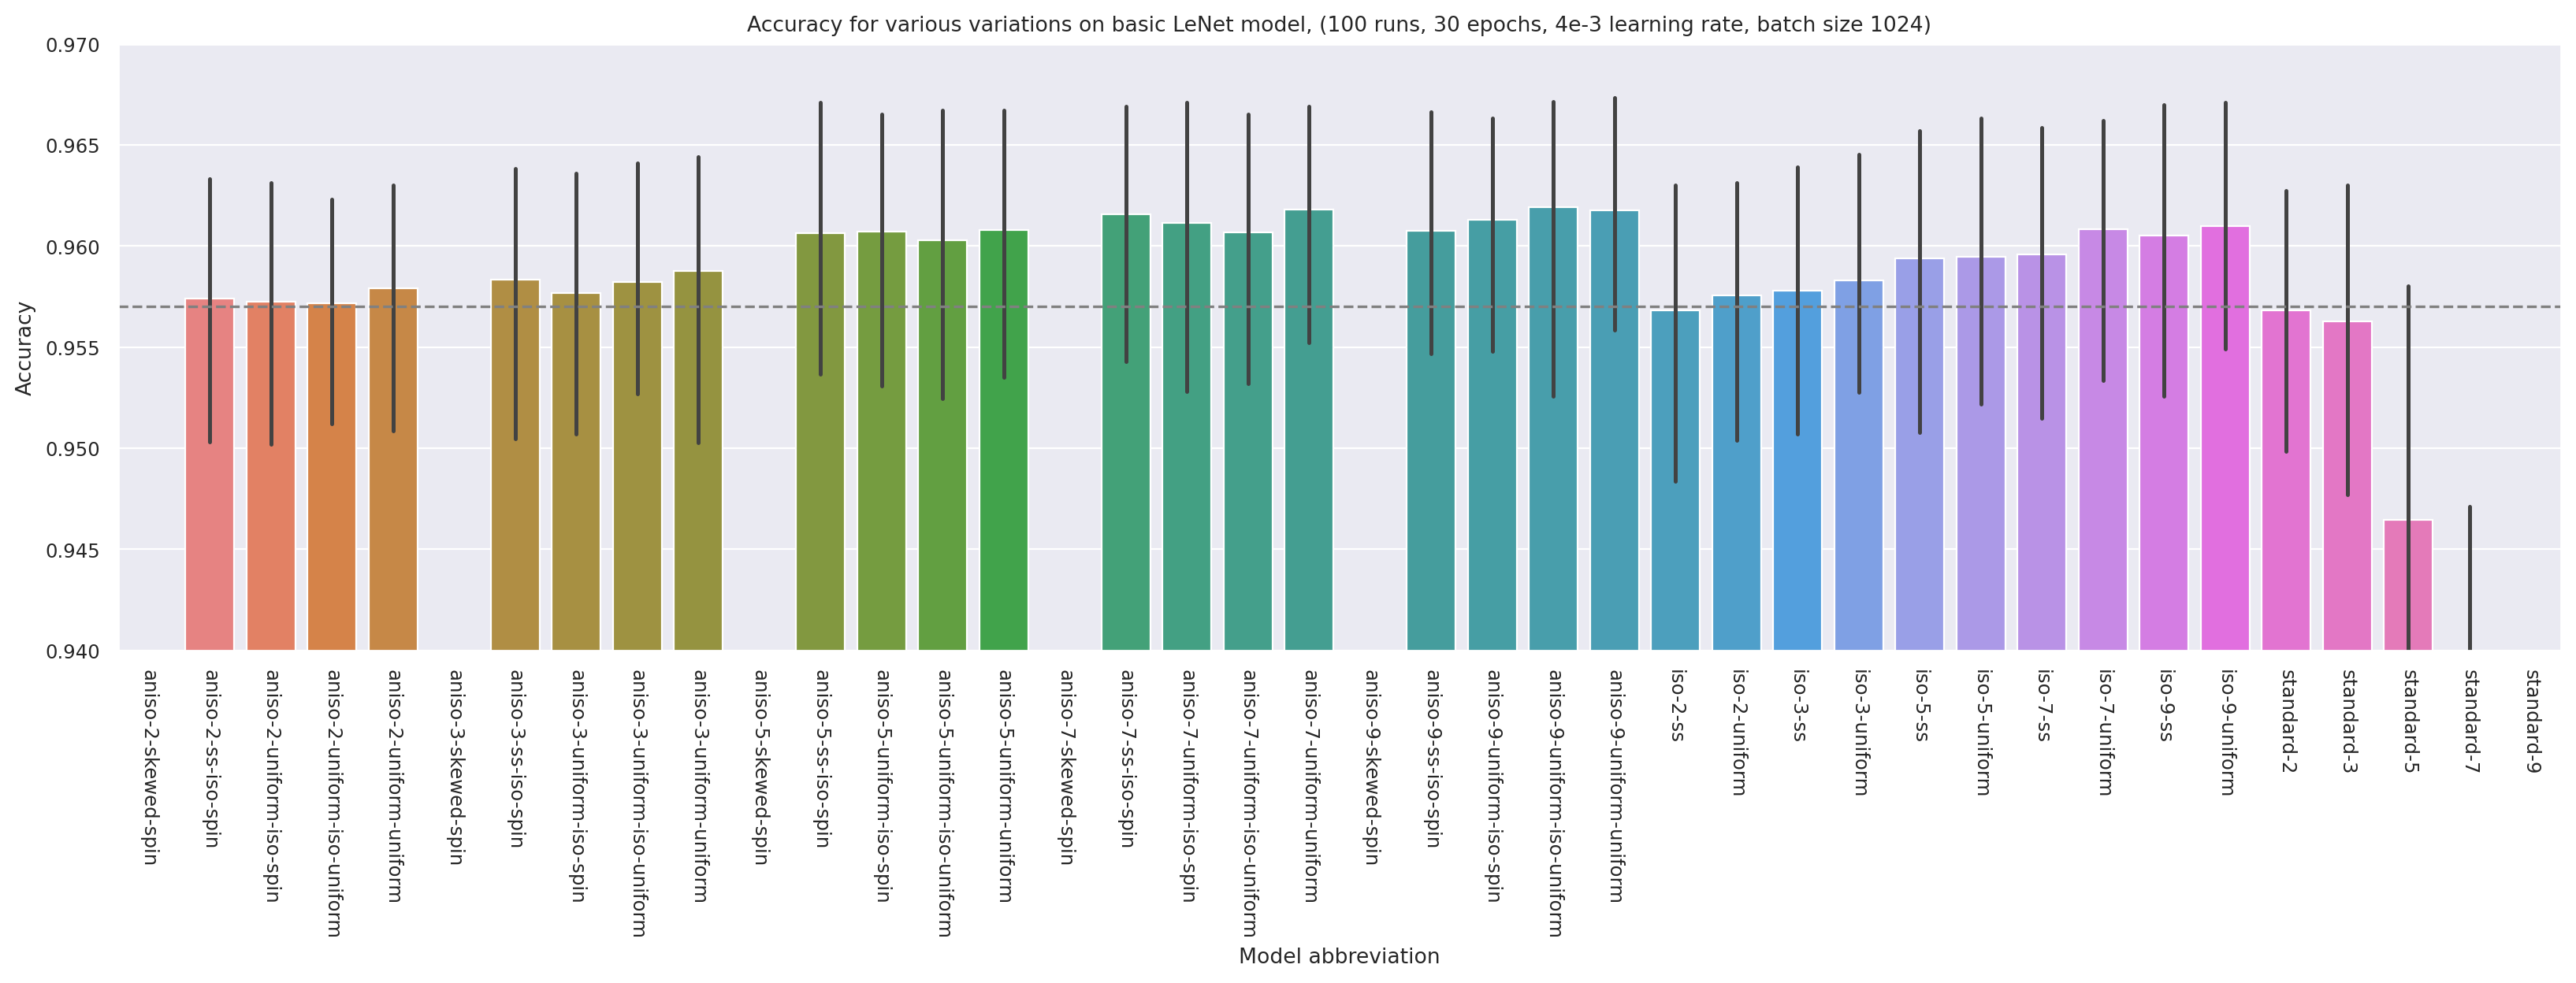

In [44]:
full_df = pl.concat((pl.scan_parquet(".data/thierry_long.pq"), pl.scan_parquet(".data/thierry_extend.pq")),
                    how='horizontal')
full_df = pl.scan_parquet(".data/long_kmnist.pq")
cols = sorted(full_df.collect_schema().names())
df = full_df.select(pl.col(cols).struct.field("acc").name.keep()).collect()
# sns.barplot({'a':[0.9471, 0.9617, 0.9567, 0.9646, 0.9506, 0.9596, 0.9531, 0.9553, 0.9578, 0.9642, 0.9532, 0.9458, 0.9513, 0.953, 0.9582, 0.9526, 0.9578, 0.9631, 0.96, 0.9557]}, errorbar=("pi", 90))
plt.figure(figsize=(20, 5), dpi=200)
sns.set_theme("paper", "darkgrid")
(sns.barplot(df.to_pandas(), errorbar=("pi", 90))
 .set(ylabel="Accuracy", xlabel="Model abbreviation",
      # title="Replication of Blankenstein's LeNet results on K-MNIST (100 runs, 5 epochs, 1e-3 learning rate, batch size 32)"
      title="Accuracy for various variations on basic LeNet model, (100 runs, 30 epochs, 4e-3 learning rate, batch size 1024)"
      ))
#
plt.xticks(rotation=-90)
plt.axhline(0.957, linestyle='dashed', color='gray')
plt.ylim(0.940, 0.97)

In [7]:
hs = {}

In [12]:
# importlib.reload(src.load_data)
# from src import load_data

# k_mnist = load_data.k_mnist()
km_tune = k_mnist.tuning_split()
print(k_mnist.y_train.dtype)

torch.int64


In [13]:
fashion_tune = load_data.fashion_mnist().tuning_split()
fashion_tune

Dataset(x_train=torch.Size([42000, 1, 28, 28]), x_test=torch.Size([18000, 1, 28, 28]), y_train=torch.Size([42000]), y_test=torch.Size([18000]))

In [9]:
cifar10_tune = cifar10.tuning_split()
cifar10_tune

Dataset(x_train=torch.Size([35000, 3, 32, 32]), x_test=torch.Size([15000, 3, 32, 32]), y_train=torch.Size([35000]), y_test=torch.Size([15000]))

In [10]:
cifar_hundred_tune = load_data.cifar100().tuning_split()
cifar_hundred_tune

Dataset(x_train=torch.Size([35000, 3, 32, 32]), x_test=torch.Size([15000, 3, 32, 32]), y_train=torch.Size([35000]), y_test=torch.Size([15000]))

In [6]:
svhn_tune = load_data.svhn().tuning_split()
svhn_tune

Dataset(x_train=torch.Size([51280, 3, 32, 32]), x_test=torch.Size([21977, 3, 32, 32]), y_train=torch.Size([51280]), y_test=torch.Size([21977]))

In [ ]:
hist = HistoryCallback(cifar_hundred_tune)
lr = 0.004
CIFAR10CNN.fit_many(cifar_hundred_tune, pool_fn="aniso-7", init={"var": "ss-iso", "theta": "spin"}, count=7,
                    epoch_callback=hist, lr=lr, batch_size=1024, epochs=400)
hs_single = {lr: hist.result()}

In [20]:
# import importlib

#
# importlib.reload(src.models.utils)
# importlib.reload(src.models.trainer)
# importlib.reload(src.models.simple_lenet)
# importlib.reload(src.models)
# importlib.reload(src.load_data)
# importlib.reload(src.kernels.quadratic)
# importlib.reload(src.kernels)
# from src.models import LeNet, EXAMPLE_POOLING_FUNCTIONS
# from src import load_data
torch.set_float32_matmul_precision("high")
hs = {}
res = {}
logspace = np.logspace(np.log10(0.0010), np.log10(0.0050), num=10).tolist()
print(logspace)
bar = tqdm.tqdm(logspace, unit="trial")
model = LeNet
for lr in bar:
    bar.set_postfix(lr=lr)
    hist = HistoryCallback(fashion_tune)
    res[f'{lr=}'] = model.fit_many(fashion_tune, pool_fn="aniso-7", init={"var": "ss-iso", "theta": "spin"}, count=7,
                                   epoch_callback=hist, lr=lr, batch_size=1024, epochs=100)
    hs[lr] = hist.result()

pl.DataFrame({str(lr): vals[0] for lr, vals in hs.items()}).write_parquet(".data/tmp_tune_svhn_2.pq")

[0.001, 0.0011958131745004018, 0.0014299691483087285, 0.0017099759466766963, 0.00204481176511479, 0.0024452128480976893, 0.002924017738212867, 0.003496578933827813, 0.004181255154751868, 0.004999999999999999]


  0%|          | 0/10 [00:00<?, ?trial/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

In [26]:
pl.read_parquet(".data/tmp_tune.pq")

0.001,0.001291549665014884,0.0016681005372000592,0.0021544346900318843,0.0027825594022071257,0.003593813663804626,0.004641588833612777,0.005994842503189409,0.007742636826811269,0.01
struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4],struct[4]
"{0.1389,0.0,0.339513,0.077811}","{0.1729,0.0,0.41353,0.120279}","{0.1549,0.0,0.427907,0.093744}","{0.1835,0.0,0.39126,0.107173}","{0.1835,0.0,0.357323,0.092197}","{0.1848,0.003945,0.396467,0.102379}","{0.1833,0.001974,0.375827,0.101505}","{0.1845,0.003914,0.431315,0.120612}","{0.1872,0.0059,0.441694,0.122478}","{0.1919,0.037418,0.420046,0.14571}"
"{0.1633,0.0,0.328063,0.105609}","{0.1551,0.0,0.320577,0.097096}","{0.2124,0.0,0.432127,0.148746}","{0.1935,0.001959,0.407659,0.135276}","{0.2365,0.01173,0.432544,0.179281}","{0.2314,0.014706,0.411713,0.170246}","{0.2642,0.009268,0.435835,0.242152}","{0.3039,0.003846,0.446287,0.261608}","{0.2855,0.028674,0.43197,0.244255}","{0.215,0.026743,0.411581,0.174714}"


In [42]:
# hs_old = hs

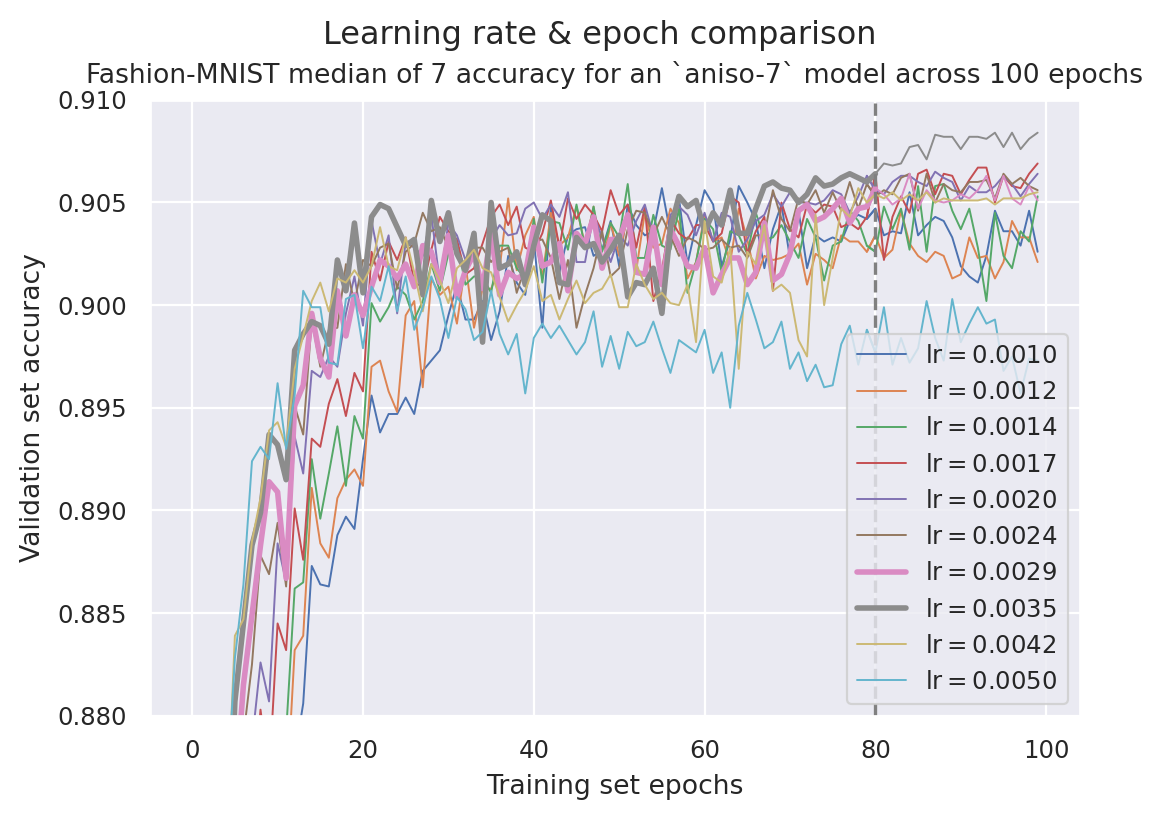

In [23]:
sns.set_theme("paper", "darkgrid")
plt.figure(dpi=200, figsize=(6, 4))
cutoff = 80
n_epochs = 100
for i, (lr, (vls, trns)) in enumerate(hs.items()):
    vals = np.median(vls["acc"].to_numpy().reshape(7, n_epochs), axis=0)
    color = plt.plot(range(cutoff + 1), vals[:cutoff + 1], label=f"lr$= {lr:.4f}$",
                     linewidth=0.7 if round(lr, 4) not in (0.0035,0.0029) else 2)[
        0].get_color()
    plt.plot(range(cutoff - 1, n_epochs), vals[cutoff - 1:], color=color, linewidth=0.7)
plt.ylim(0.88, 0.91)
# plt.ylim(0.92, 0.95)
# plt.ylim(0.79, 0.84)
plt.suptitle("Learning rate & epoch comparison")
plt.title(f"Fashion-MNIST median of 7 accuracy for an `aniso-7` model across {n_epochs} epochs")
plt.xlabel("Training set epochs")
plt.ylabel("Validation set accuracy")
plt.axvline(cutoff, linestyle='dashed', color='gray')
# plt.text(cutoff + 3, 0.91, "Proposed cutoff", color='gray')
plt.xticks([cutoff], [f"{cutoff}"], minor=True)
plt.tick_params("x", colors="gray", which="minor")
plt.legend()

In [13]:
hist = HistoryCallback(svhn_tune)
res[f'{lr=}'] = model.fit_many(svhn_tune, pool_fn="aniso-7", init={"var": "ss-iso", "theta": "spin"}, count=7,
                               epoch_callback=hist, lr=0.003, batch_size=1024, epochs=300)
hs_temp = hist.result()

aniso-7:{'var': 'ss-iso', 'theta': 'spin'}:   0%|          | 0/7 [00:00<?, ?run/s]

(0.92, 0.95)

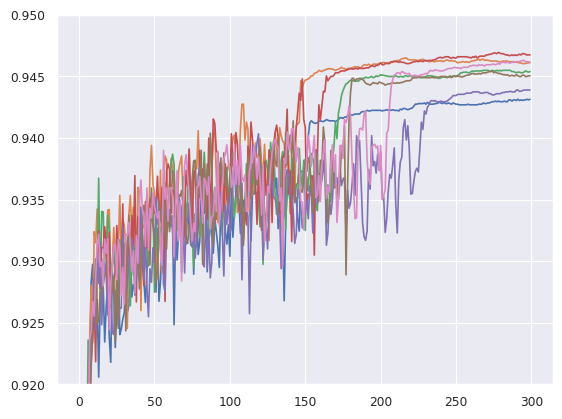

In [22]:
plt.plot(hs_temp[0]["acc"].to_numpy().reshape(7, 300).T)
plt.ylim(0.92, 0.95)

In [45]:
k_mnist

Dataset(x_train=torch.Size([60000, 1, 28, 28]), x_test=torch.Size([10000, 1, 28, 28]), y_train=torch.Size([60000]), y_test=torch.Size([10000]))

In [46]:
model = LeNet(1, 10, "aniso-7")
k0 = model.net[2].kernel()
model.fit(k_mnist, epochs=30, batch_size=1024, lr=0.004)

Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

In [54]:
k = model.net[2].kernel()
k.shape

torch.Size([20, 1, 7, 7])

In [64]:
model.evaluate(k_mnist, batch_size=10_000)

{'o': {'precision': 0.9670658682634731,
  'recall': 0.969,
  'f1-score': 0.968031968031968,
  'support': 1000.0},
 'ki': {'precision': 0.9694189602446484,
  'recall': 0.951,
  'f1-score': 0.9601211509338717,
  'support': 1000.0},
 'su': {'precision': 0.9630390143737166,
  'recall': 0.938,
  'f1-score': 0.950354609929078,
  'support': 1000.0},
 'tsu': {'precision': 0.9639024390243902,
  'recall': 0.988,
  'f1-score': 0.9758024691358025,
  'support': 1000.0},
 'na': {'precision': 0.9645030425963489,
  'recall': 0.951,
  'f1-score': 0.9577039274924471,
  'support': 1000.0},
 'ha': {'precision': 0.9765784114052953,
  'recall': 0.959,
  'f1-score': 0.9677093844601413,
  'support': 1000.0},
 'ma': {'precision': 0.9495635305528612,
  'recall': 0.979,
  'f1-score': 0.9640571147218119,
  'support': 1000.0},
 'ya': {'precision': 0.9730538922155688,
  'recall': 0.975,
  'f1-score': 0.974025974025974,
  'support': 1000.0},
 're': {'precision': 0.9635826771653543,
  'recall': 0.979,
  'f1-score': 0

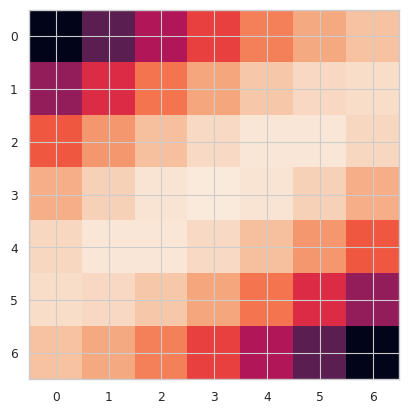

In [75]:
plt.imshow(k[8, 0].numpy(force=True))

In [76]:
torch.ones(3, device='cuda')

tensor([1., 1., 1.], device='cuda:0')

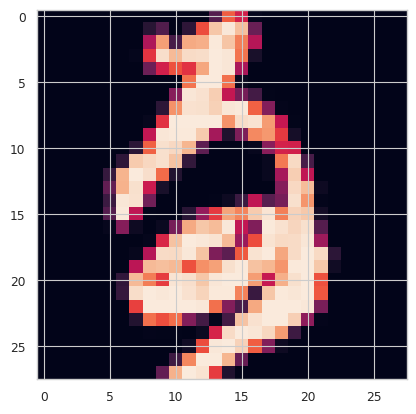

In [81]:
plt.imshow(k_mnist.x_train[4, 0])